In [1]:
# download all the packages
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision import datasets, transforms,models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# Define the data directory
data_dir = 'drive/MyDrive/animals'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets


In [4]:

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names


{'train': 4415, 'val': 985}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat',
 'caterpillar',
 'chimpanzee',
 'cockroach',
 'cow',
 'coyote',
 'crab',
 'crow',
 'deer',
 'dog',
 'dolphin',
 'donkey',
 'dragonfly',
 'duck',
 'eagle',
 'elephant',
 'flamingo',
 'fly',
 'fox',
 'goat',
 'goldfish',
 'goose',
 'gorilla',
 'grasshopper',
 'hamster',
 'hare',
 'hedgehog',
 'hippopotamus',
 'hornbill',
 'horse',
 'hummingbird',
 'hyena',
 'jellyfish',
 'kangaroo',
 'koala',
 'ladybugs',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'mosquito',
 'moth',
 'mouse',
 'octopus',
 'okapi',
 'orangutan',
 'otter',
 'owl',
 'ox',
 'oyster',
 'panda',
 'parrot',
 'pelecaniformes',
 'penguin',
 'pig',
 'pigeon',
 'porcupine',
 'possum',
 'raccoon',
 'rat',
 'reindeer',
 'rhinoceros',
 'sandpiper',
 'seahorse',
 'seal',
 'shark',
 'sheep',
 'snake',
 'sparrow',
 'squid',
 'squirrel',
 'starfish',
 'swan',
 'tiger',
 'turkey',
 'turtle',
 'whale',
 'wolf',
 'wombat',
 'woodpecker',


In [5]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 4.0058 Acc: 0.1475
val Loss: 2.3904 Acc: 0.3949
train Loss: 2.5239 Acc: 0.3706
val Loss: 1.1218 Acc: 0.6832
train Loss: 2.0154 Acc: 0.4883
val Loss: 0.8746 Acc: 0.7706
Training complete!


In [9]:

# Save the model
torch.save(model.state_dict(), 'animal_classification_model.pth')


In [10]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('animal_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 90)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:3]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:3]


# Load and preprocess the unseen image
image_path = 'drive/MyDrive/ok.jpeg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [11]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat',
 'caterpillar',
 'chimpanzee',
 'cockroach',
 'cow',
 'coyote',
 'crab',
 'crow',
 'deer',
 'dog',
 'dolphin',
 'donkey',
 'dragonfly',
 'duck',
 'eagle',
 'elephant',
 'flamingo',
 'fly',
 'fox',
 'goat',
 'goldfish',
 'goose',
 'gorilla',
 'grasshopper',
 'hamster',
 'hare',
 'hedgehog',
 'hippopotamus',
 'hornbill',
 'horse',
 'hummingbird',
 'hyena',
 'jellyfish',
 'kangaroo',
 'koala',
 'ladybugs',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'mosquito',
 'moth',
 'mouse',
 'octopus',
 'okapi',
 'orangutan',
 'otter',
 'owl',
 'ox',
 'oyster',
 'panda',
 'parrot',
 'pelecaniformes',
 'penguin',
 'pig',
 'pigeon',
 'porcupine',
 'possum',
 'raccoon',
 'rat',
 'reindeer',
 'rhinoceros',
 'sandpiper',
 'seahorse',
 'seal',
 'shark',
 'sheep',
 'snake',
 'sparrow',
 'squid',
 'squirrel',
 'starfish',
 'swan',
 'tiger',
 'turkey',
 'turtle',
 'whale',
 'wolf',
 'wombat',
 'woodpecker',
 'zebra']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: tiger


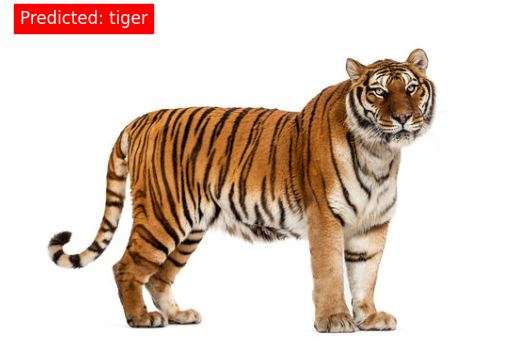

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()